# Extreme Learning Machine: Theory and Applications

The Extreme Learning Machine (ELM) is a learning algorithm for single hidden layer feedforward neural networks, that randomly initialises hidden node weights and analytically determines the output weights of the neural network.
It is known to have good generalisation performance at extremely fast learning speeds compared to standard learning algorithms for neural networks, that first appeared [here](https://web.njit.edu/~usman/courses/cs675_fall20/ELM-NC-2006.pdf).

## Learning Algorithm 
The training algorithm consists of 3 simple steps. Recall that single-layer feedforward neural networks with $\tilde{N}$ hidden nodes and activation function $g(\mathbf{x})$ on a dataset $(\mathbf{x}, \mathbf{y})$ of $N$ samles are described as

$$\sum_{i=1}^{\tilde{N}} \beta_i g_i (\mathbf{x}_j) = \sum_{i=1}^{\tilde{N}} \beta_i g_i (\mathbf{w}_i \mathbf{x}_j + b_i)=\mathbf{y}_j,~j = 1,\cdots, N $$

where $\mathbf{w}_i = [w_{i1},\cdots, w_{iN}]^T$ is the weight vector connecting the $i$th hidden node and input nodes, $\mathbf{\beta}_i=[\beta_{i1},\cdots, \beta_{iN}]^T$ is the wieght vector connecting the $i$th hidden node and the output nodes, and $b_i$ is the bias of the $i$th hidden node.

The learning algorithm consists of 3 simple steps:

* Randomly assign the input weight and bias vectors
* Compute the hidden layer output matrix $H$ as
$$ H(\mathbf{w},\mathbf{b},\mathbf{x}) = 
\begin{bmatrix} 
    g(w_1x_1+b_1) & \cdots & g(w_{\tilde{N}}x_{1} + b_{\tilde{N}}) \\
    \vdots & \ddots & \vdots\\
    g(w_{1}x_{N} + b_{1})  & \cdots & g(w_{\tilde{N}} x_{N} + b_{\tilde{N}}) 
\end{bmatrix} 
$$
* Compute the output weights $\mathbf{\beta}$ as
$$ \mathbf{\beta} = \mathbf{H}^\dagger \mathbf{y}, \mathbf{H}^\dagger = (\mathbf{H}^T \mathbf{H})^{-1} \mathbf{H}^T $$

All this is very simple to implement:

In [2]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, accuracy_score
import time

In [3]:
class ELM(nn.Module):
    
    def __init__(self, input_size, hidden_size, activation, device):
        
        super().__init__()
        
        if activation == 'tanh':      self.act = torch.tanh
        elif activation == 'sigmoid': self.act = torch.sigmoid
        elif activation == 'relu':    self.act = torch.relu
            
        # Initialise weights and biases for the hidden layer
        self.W = torch.empty(size = (input_size, hidden_size), device = device)
        self.b = torch.empty(size = (1, hidden_size), device = device)
        
        nn.init.uniform_(self.W, a = -1.0, b = 1.0)
        nn.init.uniform_(self.b, a = -1.0, b = 1.0)
    
    
    def fit(self, X, y):
        
        # Hidden layer nodes
        H = self.act(torch.mm(X, self.W) + self.b)
        
        # Moore-penrose pseudoinverse
        H = torch.pinverse(H)
        
        # Output weights
        self.betas = torch.mm(H, y)
        
        return
        
    def predict(self, X):
        
        # Hidden layer nodes
        H = self.act(torch.mm(X, self.W) + self.b)
        y = torch.mm(H, self.betas)
        
        return y
    

## Performance evaluation on regression problems

### Dummy case: SinC function

Let's approximate the SinC function, given by
$$ y(x) = \begin{cases}
    sin(x) / x, & \text{if $x \neq 0$}.\\
    1, & \text{otherwise}.
  \end{cases}
$$

on the interval $[-10, 10]$ with $x_i$ being uniformly sampled, with uniform noise distributed in $[-0.2, 0.2]$ for the training data. We'll make a 70/30 split and predict with the ELM:

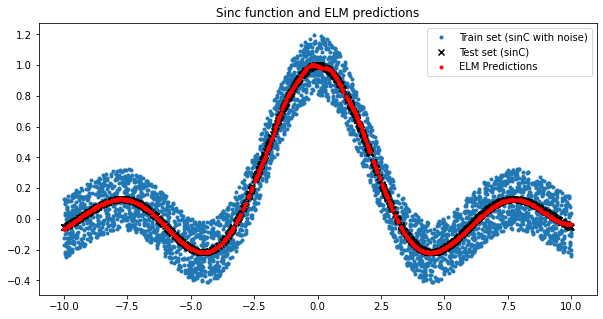

In [77]:
device = 'cpu'

# Make dataset
N = 5000
x = np.random.uniform(low = -10, high = 10, size = (N, 1))
y = np.sinc(x / np.pi)

# Corrupt targets
y_cor = y + np.random.uniform(low = -0.2, high = 0.2, size = x.shape)

# Make learning and testing indices
l = np.random.choice(np.arange(1, N), size = int(np.rint(0.8 * N)), replace = False)
t = np.setdiff1d(np.arange(1, N), l)

# Split dataset
xl, yl = x[l], y_cor[l]
xt, yt = x[t], y[t]
xl = torch.from_numpy(xl).float().to(device)
yl = torch.from_numpy(yl).float().to(device)
xt = torch.from_numpy(xt).float().to(device)


# Train / predict
elm = ELM(input_size = 1, hidden_size = 30, activation = 'tanh', device = device)
elm.fit(xl, yl)
yhat = elm.predict(xt).cpu().detach().numpy()


# Plot
plt.figure(figsize = (10, 5))
plt.scatter(xl.cpu(), yl.cpu(), marker = '.')
plt.scatter(xt.cpu(), yt, marker = 'x', color = 'k')
plt.scatter(xt.cpu(), yhat, marker = '.', color = 'r')
plt.title('Sinc function and ELM predictions')
plt.legend(['Train set (sinC with noise)', 'Test set (sinC)', 'ELM Predictions'])
plt.show()

Indeed, the ELM was able to learn the target function effectively.

## Real-world Regression Problems

We'll perform a series of real-world regression problems, as performed by the authors.
We need a few functions: A function to train a model on a training set and predict on a validation set, a function to preform k-fold cross validation, a model selection procedure, and an error estimation procedure for the complete nested k-fold process.

In [110]:
def to_tensor(arr, dev = device): 
    # Convert array to tensor and send to device
    return torch.from_numpy(arr).float().to(dev)

def train_predict(df_train, df_val, no_targets, device, hidden_size, err_fcn):
    ''' Train on a train set / predict on a test set '''
    
    # Split X,y and convert to tensors
    X_train = to_tensor(df_train[:, :-no_targets], device)
    y_train = to_tensor(df_train[:, -no_targets:], device)
    X_val   = to_tensor(df_val[:, :-no_targets], device)
    y_val   = to_tensor(df_val[:, -no_targets:], device)
    
    # Instantiate ELM
    elm = ELM(input_size  = X_train.shape[1],
              hidden_size = hidden_size,
              activation  = 'tanh',
              device      = device)

    # Train and time it
    start = time.time()
    elm.fit(X_train, y_train)
    end  = time.time()
    dur = end - start
    
    # Predict and compute error
    y_val_hat = elm.predict(X_val).cpu().detach().numpy()
    y_val     = y_val.cpu().detach().numpy()
    error     = err_fcn(y_val, y_val_hat)
    
    return dur, error

def cross_validation(df, no_targets, kfold, device, hidden_size, error_metric, scale):
    ''' Perform cross validation procedure '''
    
    # Arrays to hold results for this set
    errors, train_times = [], []

    # Loop over folds
    for train_idx, val_idx in kfold.split(df):

        # Scale
        if scale:
            scaler   = MinMaxScaler(feature_range = (0, 1))
            df_train = scaler.fit_transform(df[train_idx])
            df_val   = scaler.transform(df[val_idx])
        else:
            df_train = df[train_idx]
            df_val   = df[val_idx]

        # Train / predict
        tr_time, error = train_predict(df_train, df_val, no_targets, device, hidden_size, error_metric)
            
        # Append to lists
        errors.append(error)
        train_times.append(tr_time)
        
    return errors, train_times
            


def model_selection(df, no_targets, no_CV, device, hyperparams, scale, error_metric, seed):
    ''' Model Selection Process '''
    # Best results so far
    best_error   = np.Inf
    best_err_sd  = None
    best_time    = None
    best_neurons = None

    # Configure k-fold
    kfold = KFold(n_splits = no_CV, shuffle = True, random_state = seed)

    # Loop over the hyperprameter sets
    for hidden_size in hyperparams:

        errors, train_times = cross_validation(df, no_targets, kfold, device, hidden_size, error_metric, scale)

        # Compute median error and training time for all folds
        mean_error = np.mean(errors)
        std_error  = np.std(errors)
        mean_time  = np.mean(train_times)

        # Check if this is the lowest error obtained so far
        if mean_error < best_error:
            best_time    = mean_time
            best_error   = mean_error
            best_err_sd  = std_error
            best_neurons = hidden_size
            
    return best_error, best_err_sd, best_time, best_neurons


def error_estimation(df, no_targets, no_CV, hyperparam_set, error_metric, device, seed):
    ''' Error Estimation Process '''
    
    # Configure k-fold procedure
    kf = KFold(n_splits = no_CV, shuffle = True, random_state = seed)

    test_errors = [] # List to hold results

    for train_idx, test_idx in kf.split(df):

        # Split
        df_train = df[train_idx, :]
        df_test  = df[test_idx, :]

        # Run inner CV (model selection)
        cv_error, cv_sd_error, train_time, hidden_size = model_selection(df_train, no_targets,
                                                                         no_CV  = no_CV - 1, 
                                                                         scale  = True,
                                                                         seed   = seed,
                                                                         device = device, 
                                                                         hyperparams  = hyperparam_set,
                                                                         error_metric = error_metric)

        # Scale
        scaler   = MinMaxScaler(feature_range = (0, 1))
        df_train = scaler.fit_transform(df_train)
        df_test  = scaler.transform(df_test)

        # Train / predict
        test_time, test_error = train_predict(df_train, df_test, no_targets, device, hidden_size, error_metric)

        # Append to list of errors
        test_errors.append(test_error)

    # Grab mean and std 
    mean_test_error = np.mean(test_errors)
    std_test_error  = np.std(test_errors)
    
    return mean_test_error, std_test_error, cv_error, cv_sd_error, train_time, test_time
    

We'll check the performance on a subset of the datasets used by the authors. These include:

* **Abalone dataset**: In this [dataset](https://archive.ics.uci.edu/ml/datasets/abalone) we need to predict the age of abalone from physical measurements.  The dataset consists of 4177 instances, from which the age must be predicted from 8 features, the first of which is nominal, and all the others continuous.
* **Delta Ailerons dataset**: This [dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/delta_ailerons.html) is obtained from the task of controlling the ailerons of a F16 aircraft, containing 7129 and 5 continuous attributes.
* **Delta Elevators dataset**: This [dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/delta_elevators.html) is obtained from the task of controlling the elevators of a F16 aircraft, containing 9517 instances of 6 continuous attributes.
* **Computer Activity dataset**: This [dataset](https://sci2s.ugr.es/keel/dataset.php?cod=49#:~:text=The%20Computer%20Activity%20dataset%20is,cpus%20run%20in%20user%20mode.) is a collection of computer systems activity measures. The data was collected from a Sun Sparcstation 20/712 running in a multi-user university department. The task is to predict the portion of time that CPUs run in user mode.
There are a total of 21 continuous attributes from 8191 instances.
* **Triazines Dataset**: This [dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/DataSets.html) requires to predict the inhibition of dihydrofolate reductase by pirimidines, based on 186 instances of 60 continuous variables.
* **California Housing Dataset**: This [dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/DataSets.html) contains data drawn from the 1990 U.S. Census of California. It contains 8 continuous attributes based on which we need to estimate the median house value.

Let's see what results we're getting:

In [170]:
# Read all datasets and append them to a list
names = ['Abalone', 'Delta Ailerons', 'Delta Elevators', 'Computer Activity', 'Triazines', 'California Housing']
files = ['./datasets/abalone.data', './datasets/delta_ailerons.data', './datasets/delta_elevators.data', './datasets/compactiv.dat', './datasets/triazines.data', './datasets/cal_housing.data']
seps  = [',', ' ', ' ', ',', ',', ','] # Separators

# Define hyperparameter grid
hyper_set = np.arange(start = 5, stop = 205, step = 5, dtype = int)

# Define error metric (RMSE)
err = lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared = False)

for name, file, separator in zip(names, files, seps):
    
    # Read data
    df = pd.read_table(file, header = None, sep = separator)
    
    if name == 'Abalone':
        # One-hot encode the first column and convert to numoy array
        df = pd.concat([pd.get_dummies(df.iloc[:, 0]), df.iloc[:, 1:]], axis = 1)
        
    # Run nested k-fold CV and print results
    mean_test_error, std_test_error, cv_error, cv_sd_error, train_time, test_time = error_estimation(df.values, 
                                                                                                     no_CV  = 5,                                                       
                                                                                                     device = 'cpu', 
                                                                                                     seed   = 1,
                                                                                                     no_targets     = 1, 
                                                                                                     error_metric   = err, 
                                                                                                     hyperparam_set = hyper_set)
    
    print(f' {name:>20} Dataset | CV-RMSE: {cv_error : .4f} +- {cv_sd_error: .4f} | Test-RMSE: {mean_test_error : .4f} +- {std_test_error: .4f} | CV Training time: {train_time: .5f} sec | Test time: {test_time: .5f} sec')
        

              Abalone Dataset | CV-RMSE:  0.0792 +-  0.0030 | Test-RMSE:  0.0956 +-  0.0360 | CV Training time:  0.00252 sec | Test time:  0.00000 sec
       Delta Ailerons Dataset | CV-RMSE:  0.0410 +-  0.0015 | Test-RMSE:  0.0407 +-  0.0036 | CV Training time:  0.01013 sec | Test time:  0.01010 sec
      Delta Elevators Dataset | CV-RMSE:  0.0562 +-  0.0020 | Test-RMSE:  0.0540 +-  0.0017 | CV Training time:  0.00602 sec | Test time:  0.00900 sec
    Computer Activity Dataset | CV-RMSE:  0.0343 +-  0.0019 | Test-RMSE:  0.0336 +-  0.0030 | CV Training time:  0.02041 sec | Test time:  0.03020 sec
            Triazines Dataset | CV-RMSE:  0.1936 +-  0.0386 | Test-RMSE:  0.2331 +-  0.0342 | CV Training time:  0.00000 sec | Test time:  0.00100 sec
   California Housing Dataset | CV-RMSE:  0.1267 +-  0.0033 | Test-RMSE:  0.1318 +-  0.0108 | CV Training time:  0.02386 sec | Test time:  0.03325 sec


The above results are similar with the results reported by the authors. So far, so good.

## Real-world Classification Problems

Several classification problems were attempted with the ELM.

### Pima Indians Diabetes Dataset
First one reported by the authors was the diabetes [dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database) that was produced by the Applied Physics Laboratory of Johns Hopkins University in 1988. The diagnostic, binary valued variable investigated is whether the patient shows signs of diabetes according to World Health Organization criteria (i.e., if the 2 h post-load plasma glucose was at least 200 mg/dl at any survey examination or if found during routine medical care). The database consists of 768 women over the age of 21 resident in Phoenix, Arizona. All examples belong to either positive or negative class.

Let's what errors we get:

In [207]:
hyper_set    = np.linspace(start = 5, stop = 100, num = 20, dtype = int) # Hyperparameters for grid search
error_metric = lambda y_true, y_pred: accuracy_score(y_true, y_pred >= 0.5) # Error metric used by the authors

df = pd.read_csv('./Datasets/diabetes.csv').values # Read the data

# Run model selection & error estimation procedure
mean_test_error, std_test_error, cv_error, cv_sd_error, train_time, test_time = error_estimation(df,
                                                                                                 no_CV  = 4,
                                                                                                 device = 'cpu', 
                                                                                                 seed   = 1,
                                                                                                 no_targets     = 1,
                                                                                                 error_metric   = error_metric, 
                                                                                                 hyperparam_set = hyper_set)
    
print(f'CV-ACC: {cv_error : .4f} +- {cv_sd_error: .4f} | Test-ACC: {mean_test_error : .4f} +- {std_test_error: .4f} | CV Training time: {train_time: .4f} sec | Test time: {test_time: .4f} sec')


CV-ACC:  0.7222 +-  0.0234 | Test-ACC:  0.7773 +-  0.0251 | CV Training time:  0.0000 sec | Test time:  0.0000 sec


Similar results were reported on the original work in terms of test accuracy. Near-zero training times can be attributed to the small number of neurons selected probably.

### SatImage dataset 

This [dataset](https://www.openml.org/d/182) consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood. The aim is to predict this class, given the multi-spectral values. There are 6430 instances with 6 classes and 36 numerical attributes.

In [214]:
# Read the data
df = pd.read_csv('./Datasets/satimage.csv')
df = pd.concat([df.drop('class', axis = 1),                     # Dataframe w/o targets
                pd.get_dummies(df['class'], prefix = 'class')], # Dataframe w/ one-hot encoded targets only
               axis = 1).values # Concatenated on columns

# Hyperparameters for grid search
hyper_set    = np.linspace(start = 100, stop = 800, num = 20, dtype = int) 

# Error metric used by the authors
error_metric = lambda y_true, y_pred: accuracy_score(y_true,                        # Actual targets (binary: no_samples x no_classes)
                                                     (y_pred.max(1) == y_pred.T).T) # Predicted targets (ELM outpus = floats -> binary: no_samples x no_classes)

# Run model selection & error estimation procedure
mean_test_error, std_test_error, cv_error, cv_sd_error, train_time, test_time = error_estimation(df, 
                                                                                                 no_CV  = 5,
                                                                                                 device = 'cpu', 
                                                                                                 seed   = 123,
                                                                                                 no_targets     = 6,
                                                                                                 error_metric   = error_metric, 
                                                                                                 hyperparam_set = hyper_set)
    
print(f'CV-ACC: {cv_error : .4f} +- {cv_sd_error: .4f} | Test-ACC: {mean_test_error : .4f} +- {std_test_error: .4f} | CV Training time: {train_time: .5f} sec | Test time: {test_time: .5f} sec')

CV-ACC:  0.8589 +-  0.0092 | Test-ACC:  0.8560 +-  0.0069 | CV Training time:  0.00806 sec | Test time:  0.01216 sec


Test accuracy was reported equal to 0.89 on this dataset by the authors, whereas we achieve 0.86

### Segment Dataset

This [dataset](https://archive.ics.uci.edu/ml/datasets/Image+Segmentation) was generated by the Vision Group of the University of Massachusetts, and contains 2310 instances drawn randomly from a database of 7 outdoor images. The task is to classify each instance containing 19 numerical attributes, to one of the 7 classes:

In [225]:
df = pd.read_csv('./Datasets/segment.csv')

df = pd.concat([df.drop('class', axis = 1),                     # Dataframe w/o targets
                pd.get_dummies(df['class'], prefix = 'class')], # Dataframe w/ one-hot encoded targets only
               axis = 1).values # Concatenated on columns

# Hyperparameters for grid search
hyper_set    = np.linspace(start = 100, stop = 800, num = 20, dtype = int) 

# Error metric used by the authors
error_metric = lambda y_true, y_pred: accuracy_score(y_true,                        # Actual targets (binary: no_samples x no_classes)
                                                     (y_pred.max(1) == y_pred.T).T) # Predicted targets (ELM outpus = floats -> binary: no_samples x no_classes)

# Run model selection & error estimation procedure
mean_test_error, std_test_error, cv_error, cv_sd_error, train_time, test_time = error_estimation(df, 
                                                                                                 no_CV  = 5,
                                                                                                 device = 'cpu', 
                                                                                                 seed   = 123,
                                                                                                 no_targets     = 7,
                                                                                                 error_metric   = error_metric, 
                                                                                                 hyperparam_set = hyper_set)
    
print(f'CV-ACC: {cv_error : .4f} +- {cv_sd_error: .4f} | Test-ACC: {mean_test_error : .4f} +- {std_test_error: .4f} | CV Training time: {train_time: .5f} sec | Test time: {test_time: .5f} sec')

CV-ACC:  0.8772 +-  0.0056 | Test-ACC:  0.9260 +-  0.0091 | CV Training time:  0.12077 sec | Test time:  0.12136 sec


Test accuracy was also reported to be higher than the authors and equal to 0.95, whereas we obtain 0.926 only (that's a 3% difference approximately)

### Conclusions
The authors also conducted more experiments on several other datasets, whereas only 9 were tested here. The general conclusions were that the ELM is efficient in several applications with fast training times, and that its performance in sparse, high-dimensional applications needs to be further tested. 